# African Antelope Classification using FastAI

Interactive notebook with an end-to-end case study of creating a custom image dataset of major African antelope and training a deep convolutional neural network to classify each species.

The basic workflow is as follows:
1. Download images of each antelope and build a dataset.
2. Pre-process and prepare the dataset for learning.
3. Create a deep neural network model for classification.
4. Train the DNN using transfer learning on the data.
5. Validate and evaluate the model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
from antelope_classification import *

In [4]:
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)

In [5]:
antelopes = ANTELOPE; print(antelopes)

['kudu', 'eland', 'sable antelope', 'roan antelope', 'waterbuck', 'impala antelope', 'nyala', 'bushbuck', 'tsessebe', 'lichtensteins hartebeest', 'grey duiker', 'steenbok', 'klipspringer']


## Download image data

Download images to data directory, each species is added to its own directory.

In [6]:
download_antelope_images(DATA_PATH)

INFO:root:Directory 'data' is not empty. Skipping image download.


## Build and visualize datasets

In [7]:
DATA_PATH = Path('data')
VALID_PCT = 0.2
IMAGE_SIZE = 224
BATCH_SIZE = 32
ARCHITECTURE = models.resnet34

In [8]:
image_data = ImageDataBunch.from_folder(DATA_PATH, valid_pct=VALID_PCT,\
                                            ds_tfms=get_transforms(), size=IMAGE_SIZE,
                                            bs=BATCH_SIZE).normalize(imagenet_stats)

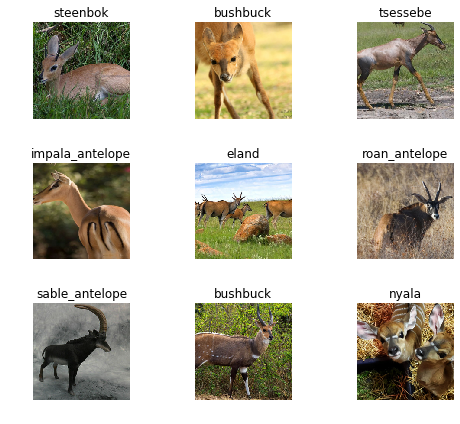

In [9]:
image_data.show_batch(3, figsize=(7,6))

In [10]:
print(image_data.classes)
len(image_data.classes), image_data.c

['bushbuck', 'eland', 'grey_duiker', 'impala_antelope', 'klipspringer', 'kudu', 'lichtensteins_hartebeest', 'nyala', 'roan_antelope', 'sable_antelope', 'steenbok', 'tsessebe', 'waterbuck']


(13, 13)

## Create Pre-trained Model

In [11]:
learn = cnn_learner(image_data, ARCHITECTURE, metrics=error_rate)

In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## Train Model

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


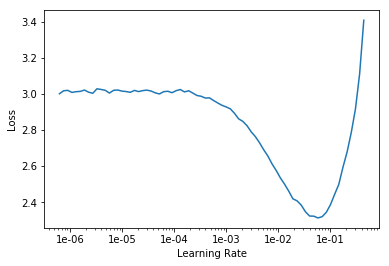

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.875314,0.821443,0.234783,00:07
1,1.272425,0.764141,0.234783,00:07
2,0.927183,0.707556,0.204348,00:07
3,0.706845,0.662003,0.191304,00:07


In [16]:
learn.save('stage-1')

## Results and Interpretation

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

In [18]:
losses, idxs = interp.top_losses()

In [19]:
len(image_data.valid_ds) == len(losses)

True

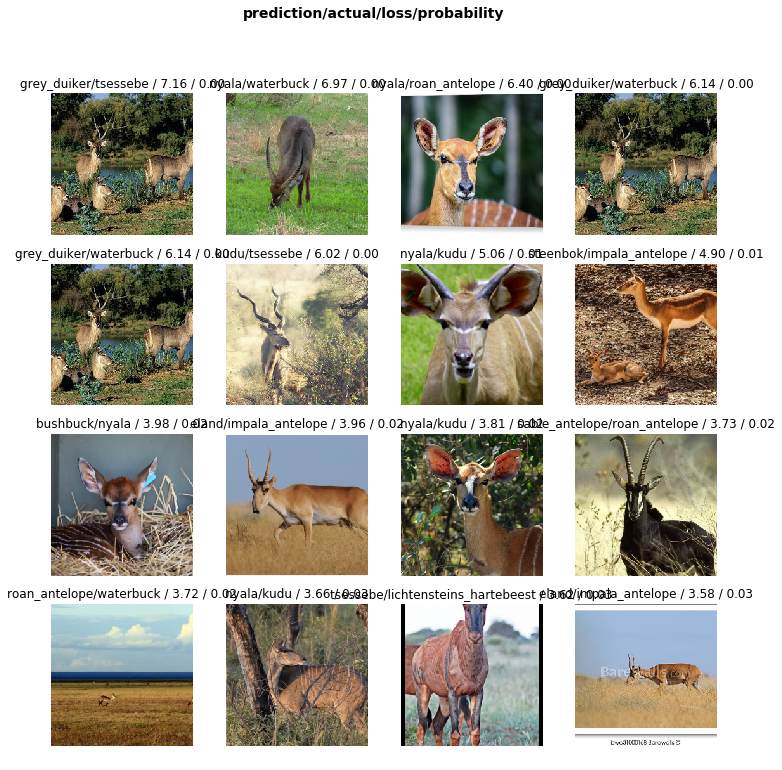

In [20]:
interp.plot_top_losses(16, heatmap=False)

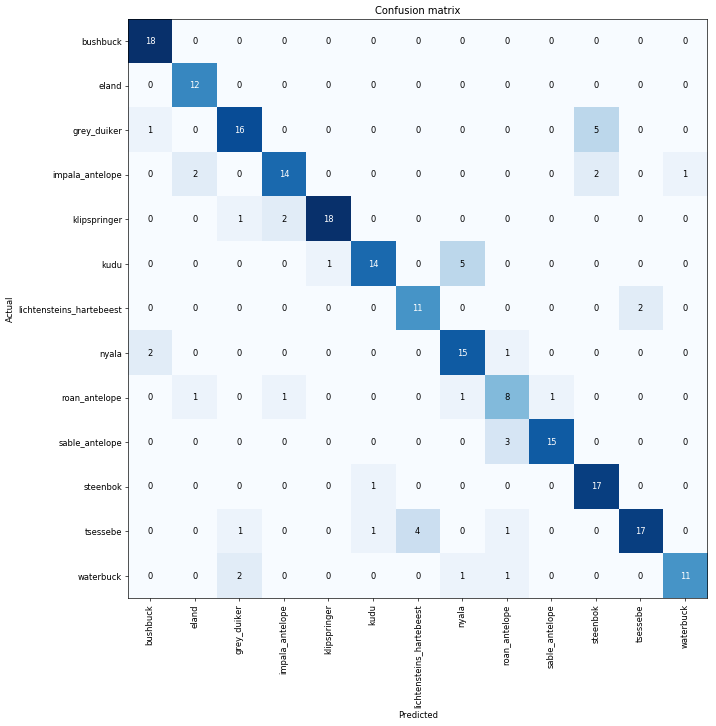

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=2)

[('grey_duiker', 'steenbok', 5),
 ('kudu', 'nyala', 5),
 ('tsessebe', 'lichtensteins_hartebeest', 4),
 ('sable_antelope', 'roan_antelope', 3),
 ('impala_antelope', 'eland', 2),
 ('impala_antelope', 'steenbok', 2),
 ('klipspringer', 'impala_antelope', 2),
 ('lichtensteins_hartebeest', 'tsessebe', 2),
 ('nyala', 'bushbuck', 2),
 ('waterbuck', 'grey_duiker', 2)]

In [23]:
learn.unfreeze()

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


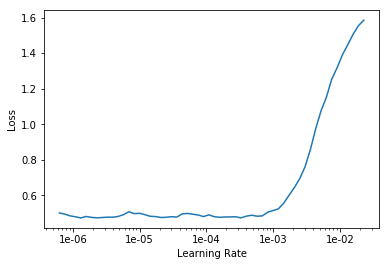

In [25]:
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.485807,0.621271,0.165217,00:08
1,0.449180,0.618828,0.169565,00:08


In [27]:
interp = ClassificationInterpretation.from_learner(learn)

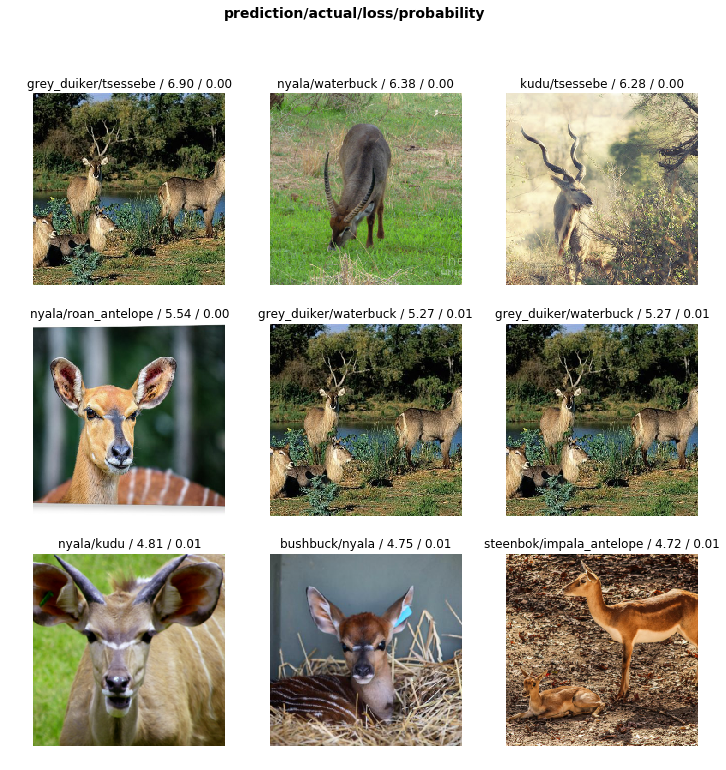

In [28]:
interp.plot_top_losses(9, figsize=(12,12), heatmap=False)